In [1]:
%matplotlib notebook
from thetis import*

In [2]:
mesh = Mesh('Mesh/mesh.msh')

In [3]:
output_dir = 'initialisation'
create_directory(output_dir)

'initialisation'

In [9]:
# typical length scale
L = 1e3

V = FunctionSpace(mesh, 'CG', 1)

# Calculate distance to open boundary
print("Calculate distance for viscosity")

bcs = [DirichletBC(V, 0.0, 100)] #make sure this matches physicalID of open boundaries

v = TestFunction(V)
u = Function(V)

solver_parameters = {
    'snes_type': 'ksponly',
    'ksp_rtol': 1e-4,
    'ksp_type': 'preonly',
    'pc_type': 'lu',
    'pc_factor_mat_solver_packages': 'mumps',
    'ksp_monitor_true_residual': True
    }

# # Before we solve the Eikonal equation, let's solve a Laplace equation to
# # generate an initial guess
F = L**2*(inner(grad(u), grad(v))) * dx - v * dx
solve(F == 0, u, bcs, solver_parameters=solver_parameters)

solver_parameters = {
     'snes_type': 'newtonls',
     'snes_monitor': True,
     'ksp_rtol': 1e-7,
         'ksp_type': 'preonly',
         'pc_type': 'lu',
         'pc_factor_mat_solver_packages': 'mumps',
         }

#epss values set the accuracy (in meters) of the final 'distance to boundary' function. To make more accurate add in extra iteration, eg, 500., 250., etc. This may result in the solver not converging.
epss = [100000.] 
# # solve Eikonal equations
for i, eps in enumerate(epss):
  print("Solving Eikonal with eps == " + str(float(eps)))
  F = inner(sqrt(inner(grad(u), grad(u))), v) * dx - v * dx + eps*inner(grad(u), grad(v)) * dx
  solve(F == 0, u, bcs, solver_parameters=solver_parameters)


chk = DumbCheckpoint(output_dir + "/dist", mode=FILE_CREATE)
with timed_stage('initialising dist'):
  dist = Function(V, name="dist")
  dist.interpolate(u)
  chk.store(dist, name="dist")
  File(output_dir + "/dist.pvd").write(u)

Calculate distance for viscosity
Solving Eikonal with eps == 100000.0


<IPython.core.display.Javascript object>


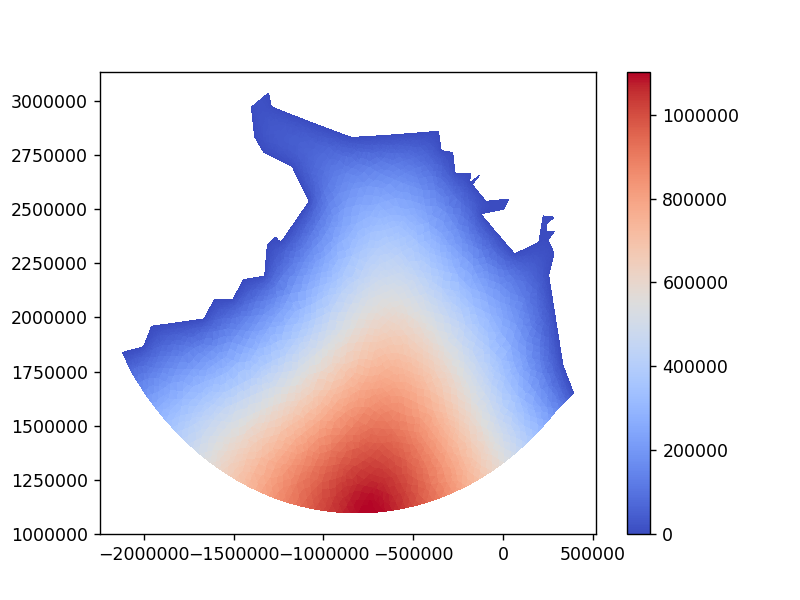

In [10]:
plot (u)

In [44]:
chk = DumbCheckpoint(output_dir + '/bathy', mode=FILE_CREATE)
with timed_stage('initialising bathy'):
  bathy = Function(V, name="bathy")
  bathy.interpolate(Max(10 * (u/10000), 10))
  chk.store(bathy, name="bathy")
  File(output_dir + '/bathy.pvd').write(bathy)

<IPython.core.display.Javascript object>


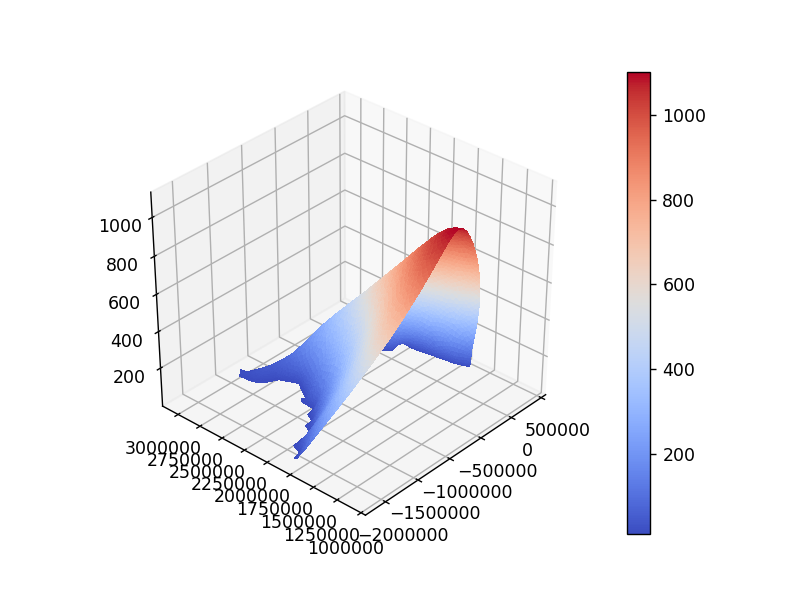

In [46]:
plot (bathy, plot3d=True)